# walkthrough of vine copula (vinecop) dataclasses and factory methods.

- Fitting

> obs -> edge -> tree -> bcp -> (next lv) obs

The function `tvc.vinecop.vcp_from_obs` takes multivariate copula observations (of shape $(n,d)$ and values inside $(0,1)$). By default at each level, it proposes potential edges between (pseudo)observations under proximity conditions, calculates corresponding bivariate dependency metrics to determine bicops-to-fit using modified Kruskal's maximum spanning tree (MST, Dissmann 2013), then fit bicops and calculates pseudo-obs for the next level using their `hfunc`.

This function can make `DataVineCop` following c/d/r-vine restrictions using Dissmann algo, and can use existing structure matrix to make `DataVineCop`.

This function can prioritize vertices inside `tpl_first` such that they can be given by user to conduct **conditional simulation**.

- Simulation (inverse Rosenblatt transform)

The `tpl_sim` attribute inside a `DataVineCop` object shows sequentially (from right to left, from shallowest to deepest) `D` pseudo-observation(on `D` levels) as source vertices to walk `D` paths until their corresponding `D` target vertices on the top level. Along each path, iteratively we do `hinv` from lower vertex to upper vertex, but may (recursively) request `hfunc` if one upper vertex is not available.

With `tpl_first` given during fitting, the fitted `DataVineCop` object allows for **conditional simulation**, where `dct_first` can be specified for `.sim()`.


In [1]:
import sys
import matplotlib.pyplot as plt
import torch

# * add proj root folder into path so `./tests` folder is searchable
sys.path.append("..")
import torchvinecopulib as tvc

print(f"cuda (GPU) avail? {torch.cuda.is_available()}\n")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_DIM = 7
num_sim = 10000
seed = 0
for _ in tvc.vinecop.__all__:
    print(f"\n{_}")
    print(tvc.vinecop.__getattribute__(_).__doc__)
print(f"\nbidep func avail: {tvc.util.ENUM_FUNC_BIDEP._member_names_}")

cuda (GPU) avail? True


DataVineCop
Dataclass for a vine copula model

vcp_from_json
load a DataVineCop from a json file

    :param f_path: path to the json file, defaults to Path("./vcp.json")
    :type f_path: Path, optional
    :return: a DataVineCop object
    :rtype: DataVineCop
    

vcp_from_obs
Construct a vine copula model from multivariate observations,
    with structure prescribed by either Dissmann's (MST per level) method or a given matrix.
    May prioritize some vertices to be first (shallower) in the quantile-regression/conditional-simulation workflow.

    :param obs_mvcp: multivariate observations, of shape (num_obs, num_dim)
    :type obs_mvcp: torch.Tensor
    :param is_Dissmann: whether to use Dissmann's method or follow a given matrix,
        defaults to True; Dissmann, J., Brechmann, E. C., Czado, C., & Kurowicka, D. (2013).
        Selecting and estimating regular vine copulae and application to financial returns.
        Computational Statistics & Data Anal

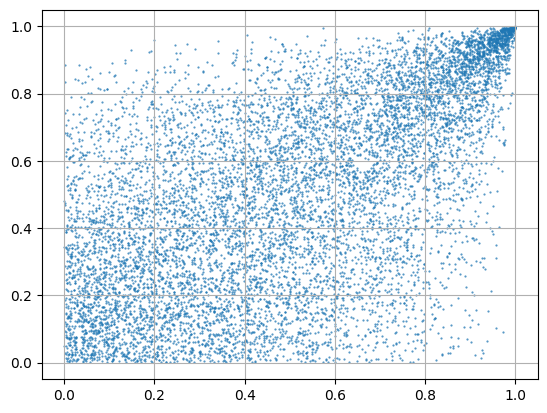

In [2]:
# simulate multivariate copula data from bicop
mdl_vcp = tvc.vinecop.vcp_from_sim(num_dim=NUM_DIM, seed=seed)
V_mvcp = mdl_vcp.sim(num_sim=num_sim, device=DEVICE)
# visualize first two dim
plt.scatter(*V_mvcp[:, [0, 1]].T.cpu(), s=0.3, alpha=0.8)
plt.grid()

## factory function


In [3]:
# make a DataVineCop object (from fitting the vinecop obs)
mdl_vcp = tvc.vinecop.vcp_from_obs(V_mvcp, tpl_fam=("Clayton",))
print(mdl_vcp)

{'mtd_bidep': 'chatterjee_xi',
 'num_dim': 7,
 'num_obs': 10_000,
 'num_par': 18,
 'negloglik': -16309.6173,
 'aic': -32583.2345,
 'bic': -32453.4484,
 'matrix': '[[ 3  6  4  5  2  1  0]'
           ' [-1  6  0  2  1  5  4]'
           ' [-1 -1  0  4  5  2  1]'
           ' [-1 -1 -1  2  4  5  1]'
           ' [-1 -1 -1 -1  1  4  5]'
           ' [-1 -1 -1 -1 -1  4  5]'
           ' [-1 -1 -1 -1 -1 -1  5]]',
 'tpl_sim': (3, 6, 0, 2, 1, 4, 5)}


## dataclass: "draw_lv"


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Vine Copula, Level 0, BiDep Metric chatterjee_xi'}>,
 <networkx.classes.graph.Graph at 0x1dd1f6dfaf0>)

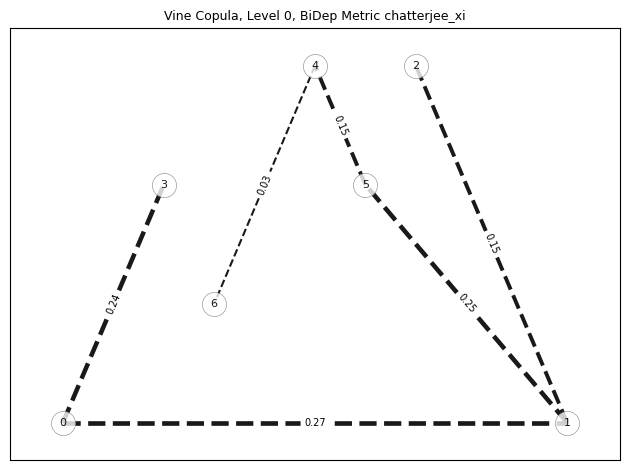

In [4]:
# for a certain level, draw the MST (of bcp) or the link between pseudo-obs
mdl_vcp.draw_lv(lv=0)

## dataclass: "cdf", "l_pdf"


In [5]:
for _ in ("cdf", "l_pdf"):
    print(f"{_}\t{mdl_vcp.__getattribute__(_)(V_mvcp)}")

cdf	tensor([[0.0039],
        [0.0011],
        [0.0037],
        ...,
        [0.0273],
        [0.0006],
        [0.0273]], device='cuda:0')
l_pdf	tensor([[3.7348],
        [2.0920],
        [1.6228],
        ...,
        [0.1007],
        [0.5758],
        [1.3739]], device='cuda:0', dtype=torch.float64)


## IO


In [6]:
import os

file = mdl_vcp.vcp_to_json()
print(file)
print(f"json IO? {mdl_vcp == tvc.vinecop.vcp_from_json(file)}")
os.remove(file)
file = mdl_vcp.vcp_to_pth()
print(file)
print(f"pth IO? {mdl_vcp == tvc.vinecop.vcp_from_pth(file)}")
os.remove(file)

vcp.json
json IO? True
vcp.pth
pth IO? True


## draw_dag and cond sim


{'mtd_bidep': 'chatterjee_xi',
 'num_dim': 7,
 'num_obs': 10_000,
 'num_par': 19,
 'negloglik': -17710.9168,
 'aic': -35383.8335,
 'bic': -35246.837,
 'matrix': '[[ 5  3  2  4  0  6  1]'
           ' [-1  3  2  4  0  6  1]'
           ' [-1 -1  2  4  0  6  1]'
           ' [-1 -1 -1  4  0  6  1]'
           ' [-1 -1 -1 -1  0  6  1]'
           ' [-1 -1 -1 -1 -1  6  1]'
           ' [-1 -1 -1 -1 -1 -1  1]]',
 'tpl_sim': (5, 3, 2, 4, 0, 6, 1)}


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Vine Copula, Obs and BiCop'}>,
 <networkx.classes.digraph.DiGraph at 0x1dd1f7c0130>)

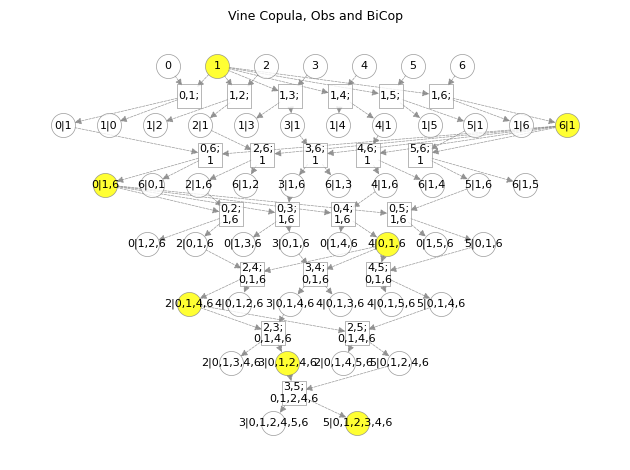

In [7]:
# give tpl_first to prioritize, show the default sim workflow (source vertices highlighted)
tpl_first = (1, NUM_DIM - 1)
mdl_vcp = tvc.vinecop.vcp_from_obs(V_mvcp, mtd_vine="cvine", tpl_first=tpl_first)
print(mdl_vcp)
mdl_vcp.draw_dag()

In [8]:
# by default, a full simulation
mdl_vcp.sim(num_sim=10000, device=DEVICE)

tensor([[0.8837, 0.8805, 0.3680,  ..., 0.0576, 0.7001, 0.9504],
        [0.6065, 0.5873, 0.3301,  ..., 0.7883, 0.6324, 0.8964],
        [0.4041, 0.3703, 0.4360,  ..., 0.3677, 0.7714, 0.3830],
        ...,
        [0.7362, 0.7913, 0.3785,  ..., 0.6467, 0.3876, 0.4240],
        [0.3678, 0.4345, 0.5457,  ..., 0.0313, 0.8933, 0.7985],
        [0.7113, 0.2341, 0.6981,  ..., 0.3712, 0.9885, 0.6304]],
       device='cuda:0', dtype=torch.float64)

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Vine Copula, Obs and BiCop'}>,
 <networkx.classes.digraph.DiGraph at 0x1df04763310>)

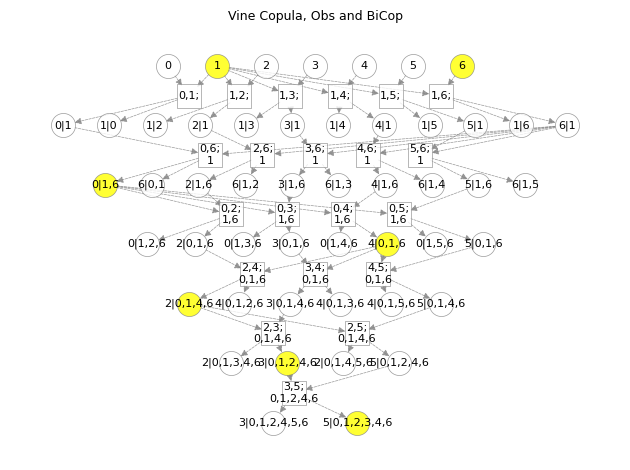

In [9]:
# show the sim workflow with tpl_first taken as simulated (source vertices highlighted), a cond sim
tpl_first_vs = tuple([(_, frozenset()) for _ in tpl_first])
mdl_vcp.draw_dag(tpl_first_vs=tpl_first_vs)

In [10]:
# prepare dct_first for a cond sim
num_sim = 10000
lst_obs = [0.7, 0.3]
dct_first_vs = {
    (idx, frozenset()): torch.ones(size=(num_sim, 1), device=DEVICE) * lst_obs[i]
    for i, idx in enumerate(tpl_first)
}
for k, v in dct_first_vs.items():
    print(k, v)

(1, frozenset()) tensor([[0.7000],
        [0.7000],
        [0.7000],
        ...,
        [0.7000],
        [0.7000],
        [0.7000]], device='cuda:0')
(6, frozenset()) tensor([[0.3000],
        [0.3000],
        [0.3000],
        ...,
        [0.3000],
        [0.3000],
        [0.3000]], device='cuda:0')


In [11]:
# NOTE cond sim: corresponding columns are preserved.
mdl_vcp.sim(num_sim=10000, dct_first_vs=dct_first_vs, device=DEVICE)

tensor([[0.8455, 0.7000, 0.7001,  ..., 0.9722, 0.1869, 0.3000],
        [0.7211, 0.7000, 0.5132,  ..., 0.6548, 0.3818, 0.3000],
        [0.8267, 0.7000, 0.0988,  ..., 0.4435, 0.4465, 0.3000],
        ...,
        [0.3101, 0.7000, 0.0894,  ..., 0.3507, 0.4616, 0.3000],
        [0.5371, 0.7000, 0.1680,  ..., 0.5077, 0.6833, 0.3000],
        [0.9323, 0.7000, 0.6079,  ..., 0.7718, 0.3262, 0.3000]],
       device='cuda:0', dtype=torch.float64)

## timeit


In [12]:
import pyvinecopulib as pvc
print(f"{tvc.__version__=}\n{pvc.__version__=}")

ctrls = pvc.FitControlsVinecop(
    family_set=[
        pvc.BicopFamily.clayton,
        pvc.BicopFamily.gumbel,
        pvc.BicopFamily.frank,
        pvc.BicopFamily.joe,
        pvc.BicopFamily.gaussian,
        pvc.BicopFamily.indep,
    ],
    parametric_method="itau",
    tree_criterion="tau",
    selection_criterion="aic",
)
lst_num_dim = [20, 40, 60, 80, 100]
for num_dim in lst_num_dim:
    num_sim = int(1000 * num_dim)
    print(f"\n{num_dim=}, {num_sim=}")
    # * same mvcop data to fit
    V_mvcp = tvc.vinecop.vcp_from_sim(num_dim=num_dim, seed=seed).sim(num_sim=5000, device=DEVICE)
    mdl_vcp = tvc.vinecop.vcp_from_obs(
        V_mvcp,
        mtd_fit="itau",
        mtd_bidep="kendall_tau",
        mtd_sel="aic",
        tpl_fam=("Clayton", "Gumbel", "Frank", "Joe", "Gaussian", "Independent"),
    )
    mdl_vcp_pvc = pvc.Vinecop(data=V_mvcp.cpu(), controls=ctrls)
    %timeit mdl_vcp.sim(num_sim=num_sim, device=DEVICE, dtype=torch.float64)
    %timeit mdl_vcp_pvc.simulate(n=num_sim, num_threads=12)

tvc.__version__='2024.8.0'
pvc.__version__='dev'

num_dim=20, num_sim=20000
430 ms ± 21.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
303 ms ± 9.48 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

num_dim=40, num_sim=40000
2.06 s ± 161 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.76 s ± 81.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

num_dim=60, num_sim=60000
4.69 s ± 113 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
7.05 s ± 308 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

num_dim=80, num_sim=80000
6.69 s ± 40.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
17.5 s ± 775 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

num_dim=100, num_sim=100000
10.9 s ± 748 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
35.6 s ± 753 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
